In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [4]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [5]:
numLayer = 2
numQubit = 1
global iterations
global noisy

In [6]:
#Create unitaries here
unitary_param_1 = np.array([])
for i in range(0, 8):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

#unitary_param_1 = [2.10501732, 5.11015318, 1.02860258, 4.19873724, 4.92982797, 0.34386221, 0.36480756, 0.03715926, 
#                   0.26142496, 3.83355082, 2.72581293, 4.00028864]

In [7]:
print(unitary_param_1)

[1.61491621 0.49548065 0.34490267 2.1055201  6.1133999  0.37979341
 0.27610679 1.48160685]


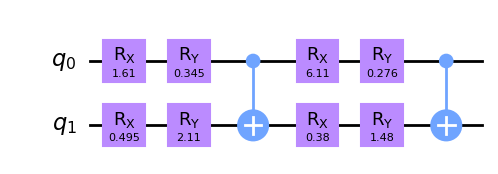

In [8]:
# First unitary
size = 2
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [9]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [23]:
def createEqSuperposCS3BSE():
    temp = QuantumCircuit(2)
    temp.ry(2*np.arctan(np.sqrt(2)), 1)
    temp.ch(1, 0)
    return temp

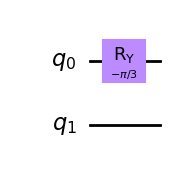

In [59]:
qcTest = QuantumCircuit(2)
qcTest.ry(-np.pi/3, 0)
qcTest.draw('mpl')

In [60]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(4)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperposCS3BSE()
    circ.append(superPosCircuit, [0, 1])

    circ.append(state, [2, 3])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [3])
    
    circ.ccx(0, 3, 2)
    circ.ccx(0, 2, 3)
    
    circ.ccx(1, 3, 2)
    circ.ccx(1, 2, 3)
    
    circ.append(superPosCircuit.inverse(), [0, 1])
    
    return circ

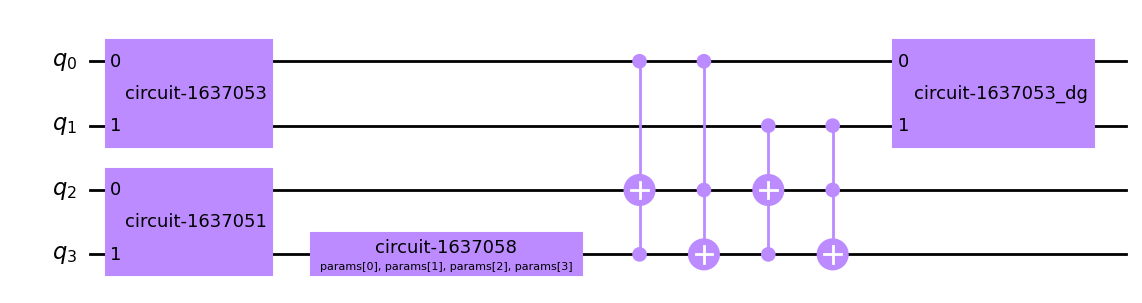

In [61]:
qCirc = createQuantumCircuit(qcTest, numQubit, numLayer)
qCirc.draw('mpl')

In [62]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [63]:
#Use if noisy
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [64]:
#Create Hamiltonian here
hamiltonian = I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [65]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [66]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [67]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3])])


In [68]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [70]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[3.39954071 1.2105191  5.86574702 5.79467732]
Initial Cost :  0.1638853326030776


In [71]:
true_value = 0.8382

In [72]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.1638853326030776
Loss Value :  0.433379028122569 1.0%
Loss Value :  0.554755321139791 2.0%
Loss Value :  0.7929052390144644 3.0%
Loss Value :  0.7929132246758351 4.0%
Loss Value :  0.8205928080879862 5.0%
Loss Value :  0.8205954157180776 6.0%
Loss Value :  0.8205979313249907 7.0%
Loss Value :  0.8209391649428284 8.0%
Loss Value :  0.8209414734052555 9.0%
Loss Value :  0.8270662397418157 10.0%
Loss Value :  0.8367209894833743 11.0%
Loss Value :  0.8372696357929703 12.0%
Loss Value :  0.837288459379184 13.0%
Loss Value :  0.8379220944167117 14.0%
Loss Value :  0.8379388638901378 15.0%
Loss Value :  0.8379547122125732 16.0%
Loss Value :  0.83795896442949 17.0%
Loss Value :  0.8379589929333101 18.0%
Loss Value :  0.8379589981348032 19.0%
Loss Value :  0.8379604392367281 20.0%
Loss Value :  0.8379757318611704 21.0%
Loss Value :  0.837975735865634 22.0%
Loss Value :  0.8380005777289111 23.0%
Loss Value :  0.8379996483828052 24.0%
Loss Value :  0.8380129974484942 25.0%
Loss 

In [73]:
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.21352401783268588
Loss Value :  0.24355045022794014 1.0%
Loss Value :  0.3269032305111294 2.0%
Loss Value :  0.33145776236689 3.0%
Loss Value :  0.29690867396306825 4.0%
Loss Value :  0.3266169929813246 5.0%
Loss Value :  0.6849647839473287 6.0%
Loss Value :  0.6723322885075292 7.0%
Loss Value :  0.6840431808829581 8.0%
Loss Value :  0.6901754772798411 9.0%
Loss Value :  0.7075365223448208 10.0%
Loss Value :  0.7074104312692194 11.0%
Loss Value :  0.7055381528707688 12.0%
Loss Value :  0.6917341838659697 13.0%
Loss Value :  0.7040616201323597 14.0%
Loss Value :  0.6994514250665949 15.0%
Loss Value :  0.6896797669196475 16.0%
Loss Value :  0.7031780430032918 17.0%
Loss Value :  0.7062920238708106 18.0%
Loss Value :  0.6914073902302629 19.0%
Loss Value :  0.6912951985395622 20.0%
Loss Value :  0.6987919484805839 21.0%
Loss Value :  0.7063363408093595 22.0%
Loss Value :  0.7031044663750304 23.0%
Loss Value :  0.703681484748999 24.0%
Loss Value :  0.6885029091965673 25.0%

In [74]:
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

0.8376751695379601


In [75]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
print("Noisy : ", noisy_loss[-1])
print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.8382
Noiseless :  0.8380241033051969
Noisy :  0.7092829328241458
Noise Resilient Value :  0.8376751695379601


In [40]:
def writeToFile():
    file = open("CS3_GBSE.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(noiseResilientValue)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noisy_loss))+"\n")
    L = [str(i)+"\n" for i in noisy_loss[0:len(noisy_loss)-1]]
    file.writelines(L)
    
    file.write(str(noisy_loss[-1]))
    
    file.close()

In [41]:
writeToFile()